# compute_full_rss_target

In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt

In [76]:
download_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed/'
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')


In [ ]:


file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name), 'r')
kspace = hf['kspace'][()]  



In [ ]:
from fastmri.fftc import ifft2c_new
from fastmri import rss_complex
from fastmri.data import transforms as T

def zero_pad_kspace(kspace, target_size=(640, 640)):
    """
    Zero-pad k-space to achieve sinc interpolation in image domain
    
    Args:
        kspace (numpy.array): K-space data (can be 2D or 3D with num_coils)
        target_size (tuple): Target size (rows, cols)
    
    Returns:
        kspace_padded (numpy.array): Zero-padded k-space
    """
    is_3d = len(kspace.shape) == 3  # Check if num_coils dimension exists
    if not is_3d:
        kspace = kspace[np.newaxis, ...]  # Add dummy coil dimension

    rows, cols = kspace.shape[-2], kspace.shape[-1]
    target_rows, target_cols = target_size

    # Convert k-space to fastMRI expected format (real, imag) -> shape (num_coils, rows, cols, 2)
    kspace_tensor = T.to_tensor(kspace)

     # Handle cropping if the size is too large
    if rows > target_rows and cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, target_size)
        rows = target_rows
        cols = target_cols

     # if only 1 dimension is too large, crop that dimension   
    if rows > target_rows:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (target_rows, cols))
        rows = target_rows
    
    if cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (rows, target_cols))
        cols = target_cols

    # Handle zero-padding if the size is too small
    if rows < target_rows or cols < target_cols:
        pad_rows = target_rows - rows
        pad_cols = target_cols - cols
        
        pad_top = pad_rows // 2
        pad_bottom = pad_rows - pad_top
        pad_left = pad_cols // 2
        pad_right = pad_cols - pad_left
        
        # Apply zero padding to 3D array
        kspace_tensor = torch.nn.functional.pad(
            kspace_tensor, (0, 0, pad_left, pad_right, pad_top, pad_bottom)
        )

    kspace_padded = T.tensor_to_complex_np(kspace_tensor)
    return kspace_padded if is_3d else kspace_padded[0]  # Remove dummy coil dimension if needed

def compute_full_rss_target(kspace, target_size=(640, 640)):
    """
    Reconstructs a fully-sampled image from zero-padded k-space and computes RSS.
    Args:
        kspace (ndarray): Fully-sampled k-space (shape: [coils, height, width])
        target_size (tuple): Desired output image size (e.g. (640, 640))
    Returns:
        dict: Dictionary containing:
            - 'image': Zero-padded RSS image of numpy array shape [H, W]
            - 'orig_shape': Original shape of the k-space data
    
    """
    kspace = zero_pad_kspace(kspace, target_size)
    image = rss_complex(ifft2c_new(T.to_tensor(kspace)))
    orig_shape = hf['kspace'].shape[-2:]

    return {'image': image.numpy(), 'orig_shape': orig_shape}

slice_id = 6
target_size = (640, 640)
new_rss = compute_full_rss_target(kspace[slice_id], target_size)

In [57]:
print(new_rss['image'].dtype)
print(new_rss['image'].shape)

print(hf['reconstruction_rss'].dtype)
print(hf['reconstruction_rss'][slice_id].dtype)
print(hf['reconstruction_rss'][slice_id].shape)
assert(hf['reconstruction_rss'][slice_id].dtype == new_rss['image'].dtype)

print(new_rss['orig_shape'])
print(hf['kspace'].shape[-2:])
assert(hf['kspace'].shape[-2:] == new_rss['orig_shape'])

float32
(640, 640)
float32
float32
(320, 320)
(640, 320)
(640, 320)


In transforms.py or mri_data.py, 

replace the use of target_image = attrs['reconstruction_rss']

with something like: target_image = compute_full_rss_target(full_kspace, target_size=(640, 640))

3. Make Sure Input and Target Match
Verify the following:

Input image from BART recon has shape [1, 640, 640]

Target image from zero-padded fully-sampled RSS also has shape [1, 640, 640]

Both are normalized similarly (important for training stability)

4. (Optional) Cache or Precompute
If reconstruction is expensive, consider saving the zero-padded RSS targets as .npy or .pt files the first time you process a volume, then load them from disk for future runs. This avoids repeated IFFT and RSS computations.

## think of an efficient way to store it so you still now original shape kspace

Step 1: Generate and Store Fully Sampled RSS Targets

=> see function: rss_full.py

✅ Step 2: Load in Your Pipeline

In [ ]:
# In your dataset class (likely in mri_data.py), modify the __getitem__ to load the .pt file instead of computing the RSS target:
def __getitem__(self, idx):
    ...
    # Replace the original target loading:
    target_dict = torch.load(os.path.join(self.rss_target_folder, f"{filename}.pt"))
    target_image = target_dict['image']
    orig_shape = target_dict['orig_shape']

In [81]:
rss_target_folder = "/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/Full_RSS_target/test/"
filename = 'file_brain_AXFLAIR_200_6002429.h5'
basename = os.path.basename(filename).replace('.h5', '')
target_dict = torch.load(os.path.join(rss_target_folder, f"{basename}_rss.pt"))
print(target_dict.keys())

print(target_dict['image'].shape)
print(target_dict['orig_shape'])



dict_keys(['image', 'orig_shape'])
torch.Size([16, 640, 640])
(640, 320)


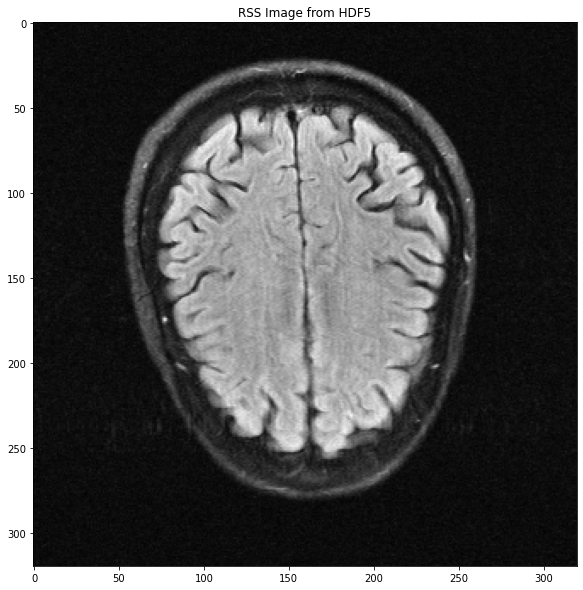

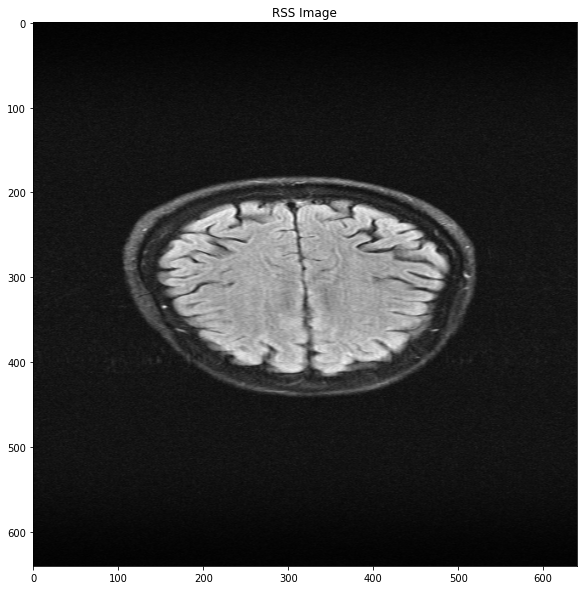

In [82]:
## compare to original reconstruction rss next to rss in dict
hf = h5py.File(os.path.join(train_path, filename), 'r')

plt.figure(figsize=(10, 10))
plt.imshow(hf['reconstruction_rss'][6], cmap='gray')
plt.title('RSS Image from HDF5')
plt.show()

# Display the RSS image for a slice
plt.figure(figsize=(10, 10))
plt.imshow(target_dict['image'][6], cmap='gray')
plt.title('RSS Image')
plt.show()



## With gpu

In [58]:
import os
import h5py
import yaml
import torch
import argparse
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

from fastmri.fftc import ifft2c_new
from fastmri import rss_complex
from fastmri.data import transforms as T

def load_config(config_path):
    with open(config_path, 'r') as f:
        return yaml.safe_load(f)

def zero_pad_kspace(kspace, target_size=(640, 640)):
    is_3d = len(kspace.shape) == 3
    if not is_3d:
        kspace = kspace[np.newaxis, ...]

    rows, cols = kspace.shape[-2:]
    target_rows, target_cols = target_size

    kspace_tensor = T.to_tensor(kspace).to('cuda')

    if rows > target_rows and cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, target_size)
        rows, cols = target_size
    if rows > target_rows:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (target_rows, cols))
        rows = target_rows
    if cols > target_cols:
        kspace_tensor = T.complex_center_crop(kspace_tensor, (rows, target_cols))
        cols = target_cols

    if rows < target_rows or cols < target_cols:
        pad_rows = target_rows - rows
        pad_cols = target_cols - cols
        pad_top = pad_rows // 2
        pad_bottom = pad_rows - pad_top
        pad_left = pad_cols // 2
        pad_right = pad_cols - pad_left
        kspace_tensor = torch.nn.functional.pad(
            kspace_tensor, (0, 0, pad_left, pad_right, pad_top, pad_bottom)
        )

    kspace_padded = T.tensor_to_complex_np(kspace_tensor.cpu())
    return kspace_padded if is_3d else kspace_padded[0]

def compute_rss_target(kspace, target_size):
    kspace_padded = zero_pad_kspace(kspace, target_size=target_size)
    image_tensor = ifft2c_new(T.to_tensor(kspace_padded).to('cuda'))
    rss_image = rss_complex(image_tensor).cpu().numpy()
    return rss_image

def process_file(file_path):
    basename = os.path.splitext(os.path.basename(file_path))[0]
    output_path = os.path.join(ARGS.output_dir, f"{basename}_rss.pt")

    with h5py.File(file_path, 'r') as hf:
        kspace = hf['kspace'][:]
        orig_shape = kspace.shape[-2:]
        all_rss = []

        for slice_idx in range(kspace.shape[0]):
            rss = compute_rss_target(kspace[slice_idx], ARGS.target_size)
            all_rss.append(rss)

        stacked = torch.tensor(np.stack(all_rss), dtype=torch.float32)
        torch.save({'rss': stacked, 'orig_shape': orig_shape}, output_path)

def parse_args():
    parser = argparse.ArgumentParser(description="Compute and save RSS targets from fastMRI k-space data.")
    parser.add_argument('--config', type=str, required=True, help='Path to config YAML file')
    return parser.parse_args()

def main():
    global ARGS
    cli_args = parse_args()
    config = load_config(cli_args.config)

    ARGS = argparse.Namespace(**config)
    os.makedirs(ARGS.output_dir, exist_ok=True)
    h5_files = [os.path.join(ARGS.input_dir, f) for f in os.listdir(ARGS.input_dir) if f.endswith('.h5')]

    with Pool(processes=min(ARGS.num_workers, cpu_count())) as pool:
        list(tqdm(pool.imap_unordered(process_file, h5_files), total=len(h5_files)))

if __name__ == '__main__':
    main()


usage: ipykernel_launcher.py [-h] --input_dir INPUT_DIR --output_dir
                             OUTPUT_DIR
                             [--target_size TARGET_SIZE TARGET_SIZE]
                             [--num_workers NUM_WORKERS]
ipykernel_launcher.py: error: the following arguments are required: --input_dir, --output_dir


SystemExit: 2

/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/conda/envs/DL_MRI_reconstruction_baselines_2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


python your_script.py --config config.yaml


## Rescaling or cropping would be needed after reconstruction

In [83]:
## Determine the Original Shape from the HDF5 File
import h5py
from pathlib import Path

def get_original_shape(h5_file_path: str) -> tuple:
    """
    Retrieve the original spatial dimensions of the k-space data from an HDF5 file.
    
    Args:
        h5_file_path: Path to the HDF5 file.
        
    Returns:
        A tuple (H, W) representing the height and width of the k-space data.
    """
    with h5py.File(h5_file_path, 'r') as f:
        # Access the 'kspace' dataset; it might have shape (num_slices, H, W) or (num_slices, coils, H, W)
        kspace = f['kspace']
        shape = kspace.shape
        if len(shape) == 3:
            # Shape: (num_slices, H, W)
            _, H, W = shape
        elif len(shape) == 4:
            # Shape: (num_slices, coils, H, W)
            _, _, H, W = shape
        else:
            raise ValueError("Unexpected k-space shape: {}".format(shape))
    return (H, W)


In [85]:
import torch.nn.functional as F
from fastmri.data import transforms as T


## Rescale an Image to the Original Shape
def resize_image(image: torch.Tensor, target_size: tuple) -> torch.Tensor:
    """
    Resize a 2D image tensor to a target size using bilinear interpolation.

    Args:
        image: Image tensor of shape (H, W) or (1, H, W)
        target_size: Tuple (new_h, new_w)

    Returns:
        Resized image tensor
    """
    if image.dtype == np.ndarray: # given is RSS reconstruction= numpy array of (H, W)
        # Convert to tensor and add batch and channel dimensions
        image = T.to_tensor(image)
    
    if image.ndim == 2:
        # Add batch and channel dimensions
        image = image.unsqueeze(0).unsqueeze(0)  # shape (1, 1, H, W)

    elif image.ndim == 3: # given is output of network= torch tensor of (1, H, W)
        # Add batch dimension
        image = image.unsqueeze(0)  # shape (1, 1, H, W) or (1, C, H, W)

    resized = F.interpolate(image, size=target_size, mode='bilinear', align_corners=False)
    return resized.squeeze()  # remove added batch and channel dims if needed

# Example usage
rss_resized = resize_image(target_dict['image'][slice_number], target_dict['orig_shape'])   

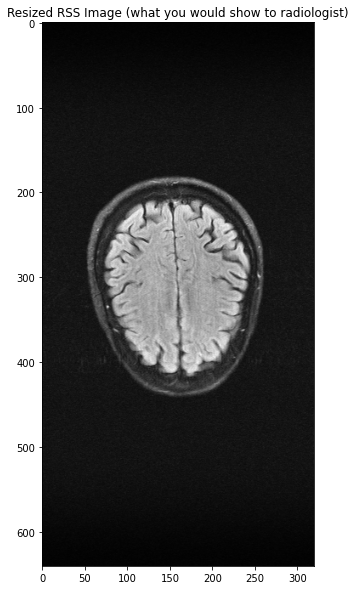

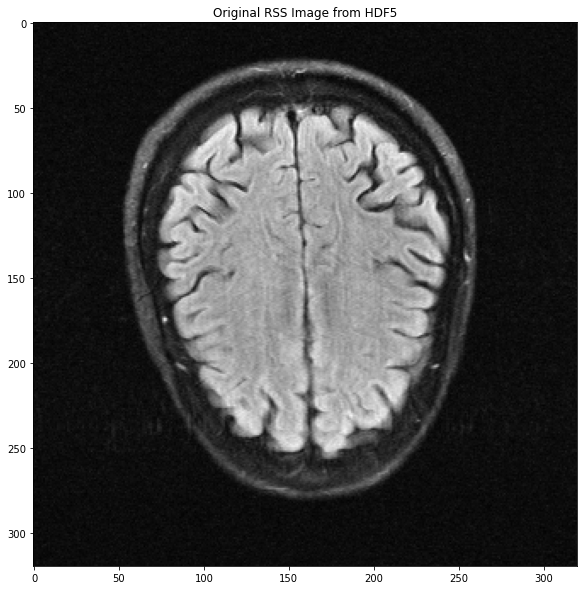

In [86]:
plt.figure(figsize=(10, 10))
plt.imshow(rss_resized, cmap='gray')
plt.title('Resized RSS Image (what you would show to radiologist)')
plt.show()

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(hf['reconstruction_rss'][slice_number], cmap='gray')
plt.title('Original RSS Image from HDF5')
plt.show()

In [87]:
## center crop + compute ssim between the two images
from skimage.metrics import structural_similarity as ssim
def compute_ssim(image1: np.ndarray, image2: np.ndarray) -> float:
    """
    Compute the Structural Similarity Index (SSIM) between two images.
    
    Args:
        image1: First image (numpy array)
        image2: Second image (numpy array)
        
    Returns:
        SSIM value
    """
    return ssim(image1, image2, data_range=image1.max())
rss_resized_cropped = T.center_crop(rss_resized, (320, 320))
## before computing ssim, ensure same data type + range

target_fastmri = hf['reconstruction_rss'][slice_number].astype(np.float32)
target_new = rss_resized_cropped.numpy().astype(np.float32)
# rescale 
target_new = (target_new - target_new.min()) / (target_new.max() - target_new.min())
target_fastmri = (target_fastmri - target_fastmri.min()) / (target_fastmri.max() - target_fastmri.min())
# Compute SSIM
ssim_value = compute_ssim(target_new, target_fastmri)
print(f"SSIM between resized RSS and original RSS: {ssim_value:.4f}")

SSIM between resized RSS and original RSS: 0.9716


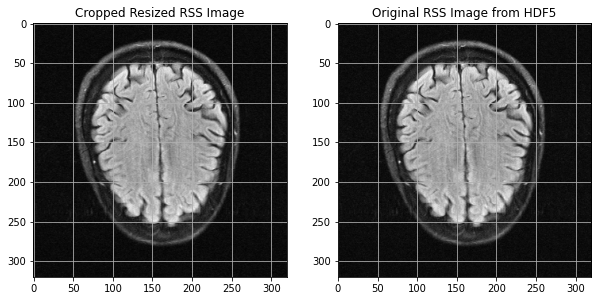

In [88]:
# plot the cropped resized image next to the original image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(rss_resized_cropped.numpy(), cmap='gray')
plt.title('Cropped Resized RSS Image')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.imshow(hf['reconstruction_rss'][slice_number], cmap='gray')
plt.title('Original RSS Image from HDF5')
plt.grid(True)
plt.show()